# Project: Investigate World Bank Open Data

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction
The [World Bank](https://data.worldbank.org/) releases a quite comprehensive  **global development data**  encompassing a wide range of developmental topics such as Agriculture & Rural Development, Economy, Health, Environment, International Trade, Urban Development etc., These are far more upto-date than the world dataset from Gapminder and in many case, Gapminder itself leverages data from World Bank for many of its indicators. In this project, we shall analyze few data pertaining to global ecnonomic & social development, published by World Bank to understand the distribution of productivity/prosperity in the world and its visible manifestations such as urbanization, CO2 emissions etc.,

#### Development Indicators
For the purpose of this study, we shall analyze the following development indicators:
1. **GDP per capita, PPP (constant 2011 international $)**
GDP per capita based on purchasing power parity (PPP). PPP GDP is gross domestic product converted to international dollars using purchasing power parity rates. An international dollar has the same purchasing power over GDP as the U.S. dollar has in the United States. GDP at purchaser's prices is the sum of gross value added by all resident producers in the economy plus any product taxes and minus any subsidies not included in the value of the products. It is calculated without making deductions for depreciation of fabricated assets or for depletion and degradation of natural resources. _Data are in constant 2011 international dollars_.
2. **CO2 emissions (metric tons per capita)**
Carbon dioxide emissions are those stemming from the burning of fossil fuels and the manufacture of cement. They include carbon dioxide produced during consumption of solid, liquid, and gas fuels and gas flaring.
3. **Urban population (% of total)**
Urban population refers to people living in urban areas as defined by national statistical offices. The data are collected and smoothed by United Nations Population Division.
4. **Agriculture, value added (% of GDP)**
Agriculture corresponds to ISIC divisions 1-5 and includes forestry, hunting, and fishing, as well as cultivation of crops and livestock production. Value added is the net output of a sector after adding up all outputs and subtracting intermediate inputs. It is calculated without making deductions for depreciation of fabricated assets or depletion and degradation of natural resources.

#### Objectives
Analyze the global development data to answer the following questions:
- Which geographic region in the world has the most productivity in 2000? Did this change by 2016? Did any region improve its overall standing compared to other regions?
- Identify the Top 10 and bottom 10 countries as per Per Capita GDP for both the base and target years. What can we say about the gap between them in 2000 and 2016? Is it widening?
- Is the productivity of a country is correlated with levels of Urbanization & prevalence of Agriculture?
- Are atmospheric CO2 emissions correlated with the productivity levels?

In [1]:
## import all necessary packages and functions.
from os import path
import csv # read and write csv files
import pprint # use to print data structures like dictionaries in
                      # a nicer way than the base print function.
import math
import numpy as np
import pandas as pd
from scipy import stats

#from prettytable import PrettyTable
from IPython.display import display, HTML

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

<a id='wrangling'></a>
## Data Wrangling

### Approach
For each indicator, data pertaining to all countries/regions for all years where measurement is made/estimated is available in a single csv file. We pull in list of countries and geographic regions from separate files and merge data from different indicator csv files. The major steps are listed below and realized in the code cells subsequent:
- Extract list of countries and put it in a dataframe (df for short, henceforth)
- Create a separate df holding list of major geographic regions and their codes
- Create dataframes for each indicator studied pulling in data from the respective csv files
- It is possible that indicator data is not available for all countries/years in question. We either exclude the country/region data from the study or substitute with data from the nearest year for which data is available.
- Create a dataframe for the geographic region holding the needed Per Capita GDP for base and target years.
- Create two distinct data frames for the base and target years holding country specific data.

In [2]:
# (1) Extract list of countries
countries_file = ".\Data\prj3\World Bank\World Bank Countries List.csv"
countries_df = pd.read_csv(countries_file, index_col='Country Code')
print (countries_df.head())
print('\n#Countries: {0}'.format(countries_df.shape[0]))

                Country Name                      Region         Income Group
Country Code                                                                 
AFG              Afghanistan                  South Asia           Low income
ALB                  Albania       Europe & Central Asia  Upper middle income
DZA                  Algeria  Middle East & North Africa  Upper middle income
ASM           American Samoa         East Asia & Pacific  Upper middle income
AND                  Andorra       Europe & Central Asia          High income

#Countries: 218


In [3]:
# (2) From the countries df, extract the geographical zone associated with each country and create 
# a dataframe containing just the list of geographic regions
georegions_df = pd.DataFrame({'GroupName' : countries_df['Region'].unique()})
print('\nGeographic Regions for Countries')
print(georegions_df)
print('\n#Geographic Regions: {0}'.format(georegions_df.shape[0]))


Geographic Regions for Countries
                    GroupName
0                  South Asia
1       Europe & Central Asia
2  Middle East & North Africa
3         East Asia & Pacific
4          Sub-Saharan Africa
5   Latin America & Caribbean
6               North America

#Geographic Regions: 7


In [4]:
# (3) Import Region data so that we can find out code for a specific geographical region
# We have all kinds of regions defined in this including sub-zones and regions based on economic status
# but we are only interested in the geographic regions captured in georegions_df above

regions_file = ".\Data\prj3\World Bank\World Regions and Codes.csv"
all_regions_df = pd.read_csv(regions_file, usecols=['GroupCode', 'GroupName']).drop_duplicates()
print(all_regions_df.head())

# Add world bank defined codes to the regions in georegions_df
georegions_df = pd.merge(georegions_df, all_regions_df, left_on='GroupName', right_on='GroupName', how='left')
georegions_df.set_index('GroupCode', inplace=True)
print('\nAfter Merging Region Codes')
print(georegions_df)
print('\n#Geographic Regions: {0}'.format(georegions_df.shape[0]))

   GroupCode                                    GroupName
0        ARB                                   Arab World
22       CEB               Central Europe and the Baltics
33       CSS                       Caribbean small states
46       EAP  East Asia & Pacific (excluding high income)
70       EAR                   Early-demographic dividend

After Merging Region Codes
                            GroupName
GroupCode                            
SAS                        South Asia
ECS             Europe & Central Asia
MEA        Middle East & North Africa
EAS               East Asia & Pacific
SSF                Sub-Saharan Africa
LCN         Latin America & Caribbean
NAC                     North America

#Geographic Regions: 7


In [5]:
# (4a) Import the global development indicators data
datadir = "./Data/prj3/World Bank/" 

gdp_key = 'GDP Per Capita'
urb_key =   '% Urbanization'
agr_key = 'Agri GDP'
co2_key = 'CO2 Emission' 

gdp_file = "API_NY.GDP.PCAP.PP.KD_DS2_en_csv_v2.csv" 
urb_file = "API_SP.URB.TOTL.IN.ZS_DS2_en_csv_v2.csv"
agr_file = "API_NV.AGR.TOTL.ZS_DS2_en_csv_v2.csv"
co2_file = "API_EN.ATM.CO2E.PC_DS2_en_csv_v2.csv"

indicators = { \
    gdp_key : { 'src' : gdp_file }, \
    urb_key : { 'src' : urb_file }, \
    agr_key : { 'src' : agr_file }, \
    co2_key : { 'src' : co2_file }, \
}

base_year = '2000'
target_year = '2016'

def fetch_indicator (fname, col1, col2) :
    fpath = path.join(datadir, fname)
    if (path.isfile(fpath) == True) :
        # A visual scan of the datafiles indicates that skiprows = 4 is required to ignore the header info (not the columns) at the top
        df = pd.read_csv (fpath, index_col = 'Country Code', skiprows=4, usecols=['Country Name', 'Country Code', col1, col2])
    else :
        df = None
        print ("file {} does not exist!".format(fpath))
    return df

for k, val in indicators.iteritems() :
    data_file = val['src']
    val['df'] =  fetch_indicator (data_file, base_year, target_year)

In [6]:
# (4b) Print a summary of the data imported.
def print_data_counts ():
    counts_df = pd.DataFrame( [val['df'].count() for k, val in indicators.iteritems() ], index = indicators.keys())
    display(counts_df)
    return

print_data_counts()

,Country Name,2000,2016
Agri GDP,264,213,194
CO2 Emission,264,245,0
GDP Per Capita,264,233,228
% Urbanization,264,261,260


### Data Cleaning

From the output of the previous cell, we can make the following observations:
1. No of rows as in the count of 'Country Name' is 264 for all the indicators. While this consistency is good, this is 46 rows more than the no of countries revealed in step (1) which is 218. _**We need to figure out the non-country data included in the csv files.**_
2. Indicator data is missing in some of the rows as the counts for base & target years are less than the total no. of rows for all the indicators. _**We shall choose only those rows, i.e. 'Country Name',  for which the indicator data is available for both the base and target years.**_
3. Indicator data is sometimes missed for one or more of the development indicators. This is evident from the fact that counts for indicatorsas reflected base and target years are different for different indicators. _**We shall choose only those 'Country Name' for which all the indicator data are available for both the base and target years.**_
4. CO2 emission data is not available for the target year 2016 (count is zero in the table above). Visual scan of the csv file confirms this is indeed due to lack of data at the source and not a programming error. **_Since the latest CO2 data available is for 2014, we shall use data from 2014 in lieu of 2016 for CO2 emissions alone._** [**Assumption:** The decision to use data from a previous year is not likely to significantly alter the direction of study findings as emission trends are generally known to be on the up -  we may just be underestimating the impact by a few notches.]

In [7]:
# We have to first fix the CO2 file missing data for whole of target year. 
# Without doing this, any subsequent dropna() leaves the whole dataframe empty!
co2_dict = indicators[co2_key]
co2_df = fetch_indicator (co2_dict['src'], base_year, '2014')   # CO2 emission per person (in metric tons)
co2_df.rename( columns = { '2014' : target_year}, inplace=True)
co2_dict['df'] = co2_df
print_data_counts()

,Country Name,2000,2016
Agri GDP,264,213,194
CO2 Emission,264,245,249
GDP Per Capita,264,233,228
% Urbanization,264,261,260


In [8]:
def is_data_present (key) :
    for k, val in indicators.iteritems():
        print('checking...{}'.format(k))
        df = val['df']
        print(key in df.index)
    return

In [9]:
# Drop rows that are missing any indicator data
def clean_missing_data() :
    for k, val in indicators.iteritems():
        #print('Cleaning...{}'.format(indicator))
        df = val['df']
        df.dropna(inplace=True)

print('\nCleaning dataframe for missing indicator values..\n')
clean_missing_data()
print_data_counts()


Cleaning dataframe for missing indicator values..



,Country Name,2000,2016
Agri GDP,178,178,178
CO2 Emission,242,242,242
GDP Per Capita,225,225,225
% Urbanization,260,260,260


In [10]:
# Round off the GDP data so that it is little easier to analyze/visualize.
gdp_df = indicators[gdp_key]['df']
gdp_df[base_year] = gdp_df[base_year].astype(int)
gdp_df[target_year] = gdp_df[target_year].astype(int)

In [11]:
# Let us examine the GDP data - identify data present other than country specific data
# First extract the index of countries and gdp dataframes, do a diff and lookup the gdp dataframe
gdp_df = indicators[gdp_key]['df']
gdp_index = gdp_df.index
countries_index = countries_df.index
non_countries_index = gdp_index.difference(countries_index)
display(gdp_df.loc[non_countries_index, :].head())

,Country Name,2000,2016
Country Code,,,
ARB,Arab World,11782,15524
CEB,Central Europe and the Baltics,14424,25231
CSS,Caribbean small states,11089,14252
EAP,East Asia & Pacific (excluding high income),4154,12843
EAR,Early-demographic dividend,5160,8548


From the above output, we infer that the indicator data for geographic regions (Arab World, South Asia etc.,) and economic regions (High Income, Low Income etc.,) is made available along with data for individual countries in the same dataframe. (This can be easily verified for all the indicator files but omitted here for bevity.) This is good since, for answering the first question, we need GDP data for geographic regions. As this is already available in the source, we don't need to estimate regional GDP based on the knowledge of countries assigned to a geography and indicator data for each country. 

We shall now proceed to construct dataframes merging the data for indicators from individual sources:
- dataframe with both base & target year GDP data for geographic regions // since we analyze only GDP data for georegions, put the data for base and target years together in the same df, making analysis a little easier
- dataframe with base year data for countries // merge data for all indicators
- dataframe with target year data for countries  //  merge data for all indicators

In [12]:
# Utility function to merge a column named 'origcol_name' from right_df to left_df  
# rename the origcol_name in the newdf to newcol_name
# Merging is based on intersection of indices from left_df & right_df
def merge_col (left_df, right_df, origcol_name, newcol_name=None):
    left_df = pd.merge(left_df, right_df[[origcol_name]], left_index=True, right_index=True, how='inner').dropna()
    if (newcol_name != None) :
        left_df.rename(columns = { origcol_name :newcol_name}, inplace=True)
    return left_df

In [13]:
# Build the GDP df  for georegions
    
print ('\nGDP Data For Regions (2000 & 2016)\n')
georegions_gdp_df = pd.DataFrame(georegions_df['GroupName'])
gdp_df = indicators[gdp_key]['df']
georegions_gdp_df = merge_col (georegions_gdp_df, gdp_df, base_year)
georegions_gdp_df = merge_col (georegions_gdp_df, gdp_df, target_year)

display (georegions_gdp_df)


GDP Data For Regions (2000 & 2016)



,GroupName,2000,2016
SAS,South Asia,2519,5620
ECS,Europe & Central Asia,22225,29161
MEA,Middle East & North Africa,13504,18069
EAS,East Asia & Pacific,7187,15786
SSF,Sub-Saharan Africa,2403,3453
LCN,Latin America & Caribbean,11337,14321
NAC,North America,45146,52306


In [14]:
# consolidate all the indicator data for the given year into the passed in dataframe
def build_yearly_df (year, df_in):
    for k, val in indicators.iteritems() :
        data_df = val['df']
        df_in = merge_col(df_in, data_df, year,  k)
        #print(df.head())
    return df_in

# build the dataframe holding country specific information for the base year
print ('\nIndicator Data For Countries (2000)\n')
countries_base_df = pd.DataFrame(countries_df['Country Name'])
countries_base_df = build_yearly_df (base_year, countries_base_df)
display (countries_base_df.head())

# build the dataframe holding country specific information for the target year
print ('\nIndicator Data For Countries (2016)\n')
countries_target_df = pd.DataFrame(countries_df['Country Name'])
countries_target_df = build_yearly_df (target_year, countries_target_df)
display (countries_target_df.head())


Indicator Data For Countries (2000)



,Country Name,Agri GDP,CO2 Emission,GDP Per Capita,% Urbanization
Country Code,,,,,
ALB,Albania,26.490462,0.978175,5668,41.741
DZA,Algeria,8.978202,2.817544,10211,59.919
ATG,Antigua and Barbuda,1.768616,4.123971,18908,32.127
ARG,Argentina,5.053021,3.835574,14899,89.142
ARM,Armenia,25.547870,1.128919,2924,64.666



Indicator Data For Countries (2016)



,Country Name,Agri GDP,CO2 Emission,GDP Per Capita,% Urbanization
Country Code,,,,,
ALB,Albania,22.894886,1.978763,11359,58.376
DZA,Algeria,13.320556,3.717410,13921,71.304
ATG,Antigua and Barbuda,1.891544,5.377649,21013,23.393
ARG,Argentina,7.560388,4.746797,18489,91.893
ARM,Armenia,17.713711,1.902759,8190,62.558


<a id='eda'></a>
## Exploratory Data Analysis

### Research Question 1 (Productivity of Geographic Regions)
Which geographic region in the world had the most productivity in 2000? Did this change by 2016? Did any region improve its overall standing compared to other regions?

In [15]:
print('\nRank Geographic Regions based on Per Capita GDP for base & target years')
georegions_gdp_df['Rank_2000'] = georegions_gdp_df[base_year].rank(ascending=False, method='dense').astype(int)
georegions_gdp_df['Rank_2016'] = georegions_gdp_df[target_year].rank(ascending=False, method='dense').astype(int)

display(georegions_gdp_df[['GroupName', 'Rank_2000','Rank_2016']].sort_values(by='Rank_2000'))

base_mean = georegions_gdp_df[base_year].mean()
base_std = georegions_gdp_df[base_year].std()
top_gdp = georegions_gdp_df[base_year].max()
min_gdp = georegions_gdp_df[base_year].min()
topper = (georegions_gdp_df.loc[georegions_gdp_df[base_year].idxmax(), 'GroupName'])
popper = (georegions_gdp_df.loc[georegions_gdp_df[base_year].idxmin(), 'GroupName'])
print('\nMost prosperous region in {}: {}'.format(base_year, topper))
print(' .... is {:.2f} std away from mean'.format ((top_gdp - base_mean)/base_std))
print('\nLeast prosperous region in {}: {}'.format(base_year, popper))
print(' .... is {:.2f} std away from mean'.format ((min_gdp - base_mean)/base_std))

target_mean = georegions_gdp_df[target_year].mean()
target_std = georegions_gdp_df[target_year].std()
min_gdp = georegions_gdp_df[target_year].min()
top_gdp = georegions_gdp_df[target_year].max()
topper = (georegions_gdp_df.loc[georegions_gdp_df['Rank_2016'] == 1, 'GroupName']).values[0]
popper = (georegions_gdp_df.loc[georegions_gdp_df[target_year].idxmin(), 'GroupName'])
print('\nMost prosperous region in {}: {}'.format(target_year, topper))
print(' .... is {:.2f} std away from mean'.format ((top_gdp - target_mean)/target_std))
print('\nLeast prosperous region in {}: {}'.format(base_year, popper))
print(' .... is {:.2f} std away from mean'.format ((min_gdp - target_mean)/target_std))


Rank Geographic Regions based on Per Capita GDP for base & target years


,GroupName,Rank_2000,Rank_2016
NAC,North America,1,1
ECS,Europe & Central Asia,2,2
MEA,Middle East & North Africa,3,3
LCN,Latin America & Caribbean,4,5
EAS,East Asia & Pacific,5,4
SAS,South Asia,6,6
SSF,Sub-Saharan Africa,7,7



Most prosperous region in 2000: North America
 .... is 2.01 std away from mean

Least prosperous region in 2000: Sub-Saharan Africa
 .... is -0.83 std away from mean

Most prosperous region in 2016: North America
 .... is 1.95 std away from mean

Least prosperous region in 2000: Sub-Saharan Africa
 .... is -0.98 std away from mean


In [16]:
def examine_rank (row):
    rank1 = row['Rank_2000']
    rank2 = row['Rank_2016']

    if (rank1 != rank2) :
        gdp1 = row[base_year]
        gdp2 = row[target_year]
        region = row['GroupName']
        rankstr = 'improved' if (rank2 < rank1) else  'dropped'
        valstr = 'decreasing' if (gdp2 < gdp1) else  'increasing'
        print('\nRegion {}  {} its rank from {:.0f} to {:.0f}'.format(region, rankstr, rank1, rank2))
        print('\t...with its Per Capita GDP {} from USD {:,.0f} to USD {:,.0f}'.format(valstr, gdp1, gdp2))
    return row

somevar = georegions_gdp_df.apply(examine_rank, axis=1)


Region East Asia & Pacific  improved its rank from 5 to 4
	...with its Per Capita GDP increasing from USD 7,187 to USD 15,786

Region Latin America & Caribbean  dropped its rank from 4 to 5
	...with its Per Capita GDP increasing from USD 11,337 to USD 14,321


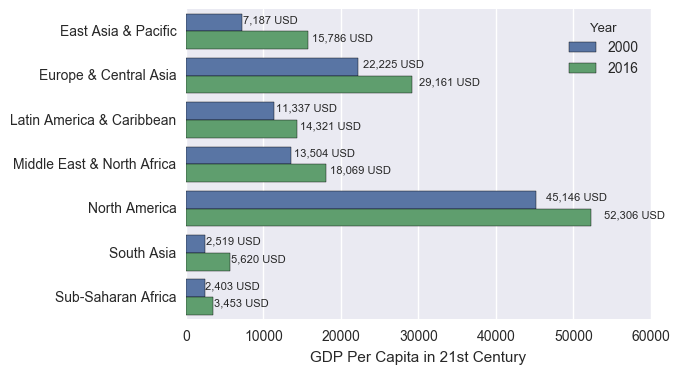

In [17]:
mgdp_regions_df = georegions_gdp_df[['GroupName', base_year, target_year]]
mgdp_regions_df = mgdp_regions_df.set_index('GroupName').sort_index()

mgdp_regions_df = mgdp_regions_df.stack().reset_index().rename(columns={'level_1': 'Year', 0: gdp_key})
#display(mgdp_regions_df)

sns.set(style="darkgrid")
ax = sns.barplot(y='GroupName', x=gdp_key, hue='Year', data=mgdp_regions_df)
ax.set(ylabel="", xlabel="GDP Per Capita in 21st Century")
for p in ax.patches:
    val = p.get_width()
    ax.annotate('{0:,.0f} USD'.format(val), (val * 1.03, p.get_y() + p.get_height()/2), fontsize=8)

sns.despine(left=True, bottom=True)

* It can be seen from the above that **Nort American region continues to be the most prosperous region** in the world.
* **East Asia & Pacific region** has surpassed Latin America & Caribbean to become the 4th most prosperous region in the world even though both of them have registered increased in prosperity as measured by per capita GDP.

### Research Question 2  (Most and Least Productive Countries)

Identify the Top 10 and bottom 10 countries as per Per Capita GDP for both the base and target years. What can we say about the gap between them in 2000 and 2016? Is it widening?

In [18]:
gdp_col = 'GDP Per Capita'
def print_gdp_df (df, dfsel) :
    print_df = df[dfsel].sort_values(by='Rank')[['Rank', 'Country Name', gdp_key]]
    print_df.reset_index (inplace = True)
    print_df.drop('Country Code', axis=1, inplace=True)
    print_df.set_index('Rank', inplace=True)
    display(HTML(print_df.to_html()))
    return

def report_ranks (df, count, year) :
    last_rank = df['Rank'].max()
    df_mean = df[gdp_col].mean()
    df_std = df[gdp_col].std()
    
    print('\nTop Ranked Countries by Per Capita GDP for the year {}'.format(year))
    dfsel = (df['Rank'] <= count)
    print_gdp_df (df, dfsel)
    top_mean = df[dfsel][gdp_col].mean()
    top_std = (top_mean - df_mean)/ df_std
    print('Mean Per Capita of Top 10 Countries: {:.2f}, normalized to std {:.2f} '.format(top_mean, top_std))
    
    print('\nLeast Ranked Countries by Per Capita GDP for the year {}'.format(year))
    dfsel = (df['Rank'] > (last_rank - count))
    btm_mean = df[dfsel][gdp_col].mean()
    btm_std = (btm_mean - df_mean)/ df_std
    print_gdp_df (df, dfsel)
    print('Mean Per Capita of Bottom 10 Countries: {:.2f}, normalized to std {:.2f} '.format(btm_mean, btm_std))
    return

countries_base_df['Rank'] = countries_base_df[gdp_key].rank(method='dense', ascending=False).astype('int32')
report_ranks(countries_base_df, 10, base_year)

countries_target_df['Rank'] = countries_target_df[gdp_key].rank(method='dense', ascending=False).astype('int32')
report_ranks(countries_target_df, 10, target_year)


Top Ranked Countries by Per Capita GDP for the year 2000


,Country Name,GDP Per Capita
Rank,,
1,Qatar,108323
2,Brunei Darussalam,82049
3,Luxembourg,81689
4,Norway,58045
5,Singapore,51698
6,Switzerland,50775
7,Saudi Arabia,43071
8,Denmark,42337
9,Netherlands,41721


Mean Per Capita of Top 10 Countries: 59870.80, normalized to std 2.65 

Least Ranked Countries by Per Capita GDP for the year 2000


,Country Name,GDP Per Capita
Rank,,
128,Uganda,1049
129,Chad,993
130,Sierra Leone,912
131,Malawi,865
132,Liberia,838
133,Central African Republic,819
134,Burundi,754
135,Ethiopia,618
136,Mozambique,561


Mean Per Capita of Bottom 10 Countries: 793.80, normalized to std -0.76 

Top Ranked Countries by Per Capita GDP for the year 2016


,Country Name,GDP Per Capita
Rank,,
1,Qatar,118207
2,Luxembourg,94764
3,Singapore,81443
4,Brunei Darussalam,71788
5,Norway,64179
6,Ireland,62991
7,Switzerland,57430
8,"Hong Kong SAR, China",54279
9,Saudi Arabia,50458


Mean Per Capita of Top 10 Countries: 70284.10, normalized to std 2.64 

Least Ranked Countries by Per Capita GDP for the year 2016


,Country Name,GDP Per Capita
Rank,,
128,Guinea-Bissau,1491
129,Madagascar,1396
130,Togo,1382
131,Sierra Leone,1368
132,Mozambique,1128
133,Malawi,1083
134,Liberia,753
135,"Congo, Dem. Rep.",743
136,Burundi,721


Mean Per Capita of Bottom 10 Countries: 1071.20, normalized to std -0.90 


- From the above output, we can infer:
    - the top 10 rich countries continue to be at the same level ~2.6 std from the mean
    - the bottom 10 poor countries slip from -0.77 std to -0.9 std from the mean.
We can therefore conclude that the **gap between rich & poor countries has indeed widened in the period from 2000 to 2016**.

- We see that **8 out of top 10** countries and **8 out of bottom 10** countries remain in the list.  

- Even with increased per capita GDP, some countries have reduced in their standings (as other countries have surpassed them). This leads to the questions:
    - How many countries actually increased their per capita GDP?
    - How many countries experienced a decrease in their per capita GDP?
    - Are there countries that grew better than others? That is, how many countries improved their relative standing (when ranked by per capita) and how many countries experienced a dip in their standing?

In [19]:
rank_base = 'Rank_2000'
rank_target = 'Rank_2016'
rank_jump = 'Rank_Jump'
rank_change = 'Rank_Change'
count = countries_df.shape[0]

country_changes_df = pd.DataFrame(countries_base_df[['Country Name']])
country_changes_df[gdp_key] = countries_target_df[gdp_key] - countries_base_df[gdp_key]
country_changes_df[rank_base] = countries_base_df['Rank']
country_changes_df[rank_target] = countries_target_df['Rank']
country_changes_df[rank_jump] = (countries_base_df['Rank'] - countries_target_df['Rank'])
country_changes_df.astype( { rank_jump : 'int32' })
#country_changes_df[rank_change] = pd.cut(country_changes_df[rank_jump], [-1.0 * count,0,1, count], right=False, labels=["drop", "nochange", "improve"])

gdp_growth_mean = country_changes_df[gdp_key].mean()
gdp_growth_std = country_changes_df[gdp_key].std(ddof=0)
print('\nGDP Per Capita growth Mean: {:.2f}, std: {:.2f}'.format(gdp_growth_mean, gdp_growth_std))


GDP Per Capita growth Mean: 4617.12, std: 5143.93


In [20]:
dfg = country_changes_df[country_changes_df[gdp_key] > 0]
num_gdp_increases = dfg[gdp_key].count()
increases_mean = dfg[gdp_key].mean()
increases_std = (increases_mean - gdp_growth_mean) / gdp_growth_std
print('\nNo of countries that reported increase in per capita GDP: {}, mean: {:.2f}, std: {:.2f}'.format(num_gdp_increases, increases_mean, increases_std))


No of countries that reported increase in per capita GDP: 127, mean: 5139.90, std: 0.10


In [21]:
dfg = country_changes_df[country_changes_df[gdp_key] < 0]
num_gdp_decreases = dfg[gdp_key].count()
decreases_mean = dfg[gdp_key].mean()
decreases_std = (decreases_mean - gdp_growth_mean) / gdp_growth_std
print('No of countries that reported decrease in per capita GDP: {}, mean: {:.2f}, std: {:.2f}'.format(num_gdp_decreases, decreases_mean, decreases_std))

No of countries that reported decrease in per capita GDP: 10, mean: -2022.20, std: -1.29


In [22]:
dfg = country_changes_df[country_changes_df[rank_jump] > 0]
num_rank_improves = dfg[gdp_key].count()
improvement_mean = dfg[gdp_key].mean()
improvement_std = (improvement_mean - gdp_growth_mean) / gdp_growth_std
print('No of countries that reported improvement in their standings: {}, mean: {:.2f}, std: {:.2f}'.format(num_rank_improves, improvement_mean, improvement_std))

No of countries that reported improvement in their standings: 56, mean: 7820.04, std: 0.62


Even though 127 countries managed to increase their productivity, 56 of them improved their relative standing by doing better than their counterparts. The mean GDP growth of these 56 is 0.62 standard deviations above the mean.

In [23]:
dfg = country_changes_df[country_changes_df[rank_jump] < 0]
num_rank_drops = dfg[gdp_key].count()
drop_mean = dfg[gdp_key].mean()
drop_std = (drop_mean - gdp_growth_mean) / gdp_growth_std
print('No of countries that reported drop in their standings: {}, mean: {:.2f}, std: {:.2f}'.format(num_rank_drops, drop_mean, drop_std))

No of countries that reported drop in their standings: 75, mean: 2155.39, std: -0.48


In [24]:
dfg = country_changes_df[country_changes_df[rank_jump] == 0]
num_rank_unchanged = dfg[gdp_key].count()
unchange_mean = dfg[gdp_key].mean()
unchange_std = (unchange_mean - gdp_growth_mean) / gdp_growth_std
print('No of countries that reported no change in their standings: {}, mean: {:.2f}, std: {:.2f}'.format(num_rank_unchanged, unchange_mean, unchange_std))

No of countries that reported no change in their standings: 6, mean: 5494.83, std: 0.17


It should be noted that 75 countries  dropped in their standings with their mean growth below the overall mean GDP growth. While the few that retained their standings have mean GDP growth above the overall mean but below the mean of countries that reported improvement in standings.

### Research Question 3  (Correlation Analysis)

- Is the productivity of a country is correlated with levels of Urbanization & prevalence of Agriculture?
- Are atmospheric CO2 emissions correlated with the productivity levels?

In [25]:
def correlation(x, y):
    '''Each input is either a NumPy array or a Pandas Series.
      correlation = average of (x in standard units) times (y in standard units)
    '''
    norm_x = (x - x.mean()) / x.std(ddof=0)
    norm_y = (y - y.mean()) / y.std(ddof=0)
    pearson_r = (norm_x * norm_y).mean()
    return pearson_r

def calc_corrs (datadf, cols) :
    corr_df = pd.DataFrame(index=cols, columns=cols)

    # We need to use loops as apply/applymap do not provide us with the row/col names 
    # in an easily retrievable way
    for r in cols:
        for c in cols:
            if pd.notna(corr_df.loc[c,r]) :
                corr_df.loc[r,c] = corr_df.loc[c,r]
            elif pd.isna(corr_df.loc[r,c]) :
                corr_df.loc[r,c] = correlation (datadf[r], datadf[c])
    return corr_df

cols = [ agr_key, co2_key, gdp_key, urb_key]


print('Pearson Correlation for Indicators ({})'.format(base_year))
base_corrs = calc_corrs(countries_base_df, cols)
display(base_corrs)

print('\nPearson Correlation for Indicators ({})'.format(target_year))
target_corrs = calc_corrs(countries_target_df, cols)
display(target_corrs)

Pearson Correlation for Indicators (2000)


,Agri GDP,CO2 Emission,GDP Per Capita,% Urbanization
Agri GDP,1,-0.472356,-0.568627,-0.659725
CO2 Emission,-0.472356,1,0.821014,0.512987
GDP Per Capita,-0.568627,0.821014,1,0.625978
% Urbanization,-0.659725,0.512987,0.625978,1



Pearson Correlation for Indicators (2016)


,Agri GDP,CO2 Emission,GDP Per Capita,% Urbanization
Agri GDP,1,-0.471401,-0.593579,-0.585331
CO2 Emission,-0.471401,1,0.75814,0.401141
GDP Per Capita,-0.593579,0.75814,1,0.620484
% Urbanization,-0.585331,0.401141,0.620484,1


In [26]:
print('Pearson Correlation for Indicators ({})'.format(base_year))
display(countries_base_df[[agr_key, co2_key, gdp_key, urb_key]].corr(method='pearson'))

print('\nPearson Correlation for Indicators ({})'.format(target_year))
display(countries_target_df[[agr_key, co2_key, gdp_key, urb_key]].corr(method='pearson'))

Pearson Correlation for Indicators (2000)


,Agri GDP,CO2 Emission,GDP Per Capita,% Urbanization
Agri GDP,1.000000,-0.472356,-0.568627,-0.659725
CO2 Emission,-0.472356,1.000000,0.821014,0.512987
GDP Per Capita,-0.568627,0.821014,1.000000,0.625978
% Urbanization,-0.659725,0.512987,0.625978,1.000000



Pearson Correlation for Indicators (2016)


,Agri GDP,CO2 Emission,GDP Per Capita,% Urbanization
Agri GDP,1.000000,-0.471401,-0.593579,-0.585331
CO2 Emission,-0.471401,1.000000,0.758140,0.401141
GDP Per Capita,-0.593579,0.758140,1.000000,0.620484
% Urbanization,-0.585331,0.401141,0.620484,1.000000


From the above correlation data, we can infer:
- Agriculture GDP & CO2 are negatively correlated (intuitively makes sense since agriculture does not consume as much as energy and therefore as much emissions as industrialization).
- Agriculture GDP & GDP Per Capita are negatively correlated (makes sense as society is getting more industrialized & technology driven)
- GDP Per Capita & % Urbanization are positively correlated (perhaps because new age industries are clustered in urban areas)
- GDP Per Capita & CO2 Emission are strongly correlated (understandable due to increased usage of fossil fuel and thereby increased emissions for higher levels of output)
- % Urbanization & CO2 emission are somewhat positively correlated (perhaps due to increased transport & energy consumptions in urban areas)
- % Urbanization & Agriculture GDP are negatively correlated (Agriculture is predominantly rural driven activity)

While we have tried to make sense of the correlations, the exact cause-effect analysis are beyond the scope of this study. 

The correlations seen in 2000 data and the correlations seen in 2016 data are not directionally different but the strength of correlation coefficient have changed from 2000 to 2016. This may require deeper analysis with more data points (such as has more eneregy from renewable sources led to reduction in growth of emissions?) which is beyond the scope of this study.

Let us now visualize the correlations using seaborn.

In [27]:
def print_gdp_co2 (df, year):
    grid = sns.JointGrid(x=gdp_key, y=co2_key, data=df, xlim=(0,50000), ylim=(0,16))
    grid.plot_joint(plt.scatter, color="g")
    grid.plot_marginals(sns.rugplot, height=1, color="g")
    grid.annotate(stats.pearsonr)
    grid.set_axis_labels('{} ({})'.format(gdp_key, year), '{} ({})'.format(co2_key, year))
    return

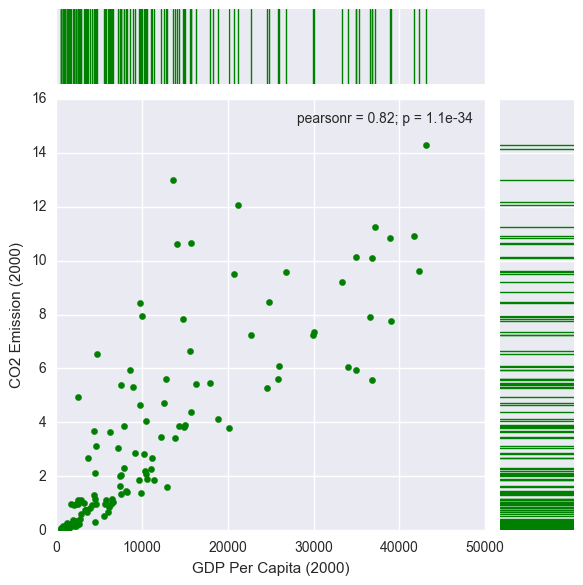

In [28]:
print_gdp_co2(countries_base_df, base_year)

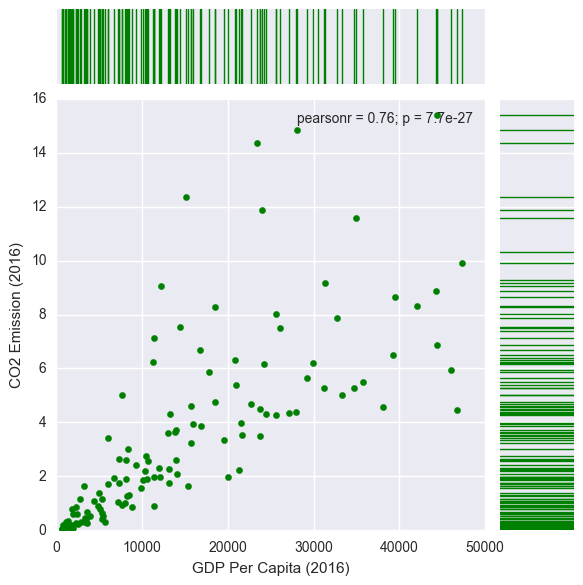

In [29]:
print_gdp_co2 (countries_target_df, target_year)

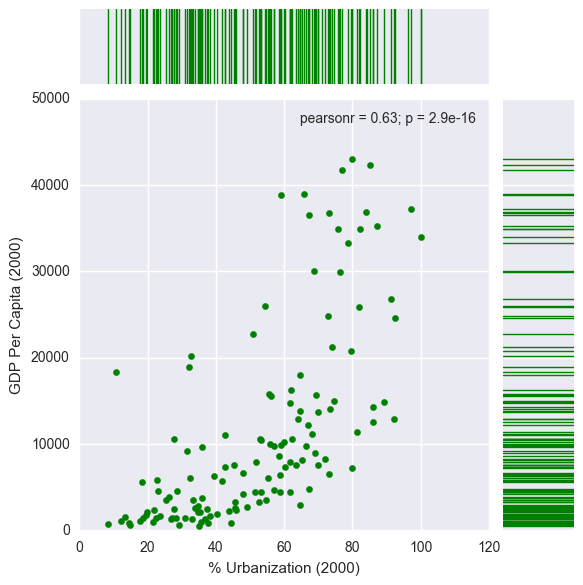

In [30]:
grid = sns.JointGrid(x=urb_key, y=gdp_key, data=countries_base_df, ylim=(0,50000))
grid.plot_joint(plt.scatter, color="g")
grid.plot_marginals(sns.rugplot, height=1, color="g")
grid.annotate(stats.pearsonr)
grid.set_axis_labels('{} ({})'.format(urb_key, base_year), '{} ({})'.format(gdp_key, base_year))

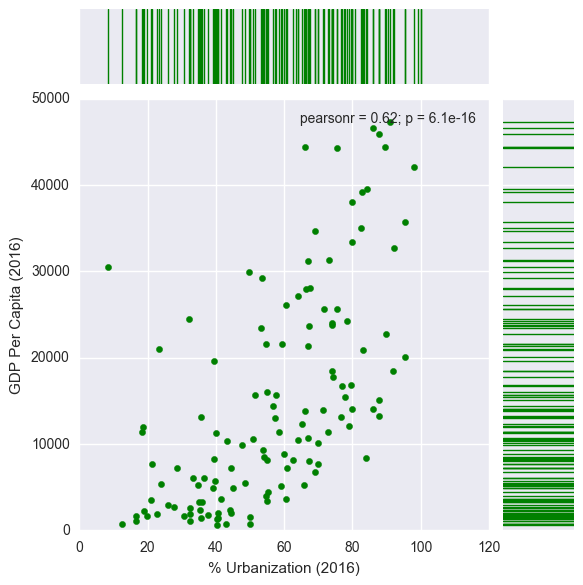

In [31]:
grid = sns.JointGrid(x=urb_key, y=gdp_key, data=countries_target_df, ylim=(0,50000))
grid.plot_joint(plt.scatter, color="g")
grid.plot_marginals(sns.rugplot, height=1, color="g")
grid.annotate(stats.pearsonr)
grid.set_axis_labels('{} ({})'.format(urb_key, target_year), '{} ({})'.format(gdp_key, target_year))

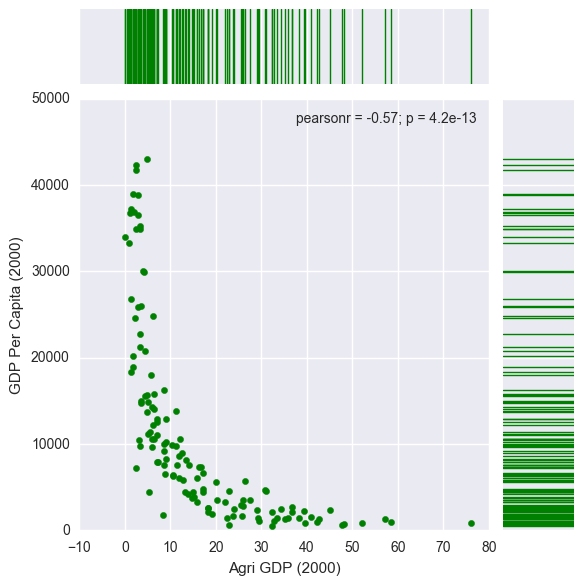

In [32]:
grid = sns.JointGrid(x=agr_key, y=gdp_key, data=countries_base_df, ylim=(0,50000))
grid.plot_joint(plt.scatter, color="g")
grid.plot_marginals(sns.rugplot, height=1, color="g")
grid.annotate(stats.pearsonr)
grid.set_axis_labels('{} ({})'.format(agr_key, base_year), '{} ({})'.format(gdp_key, base_year))

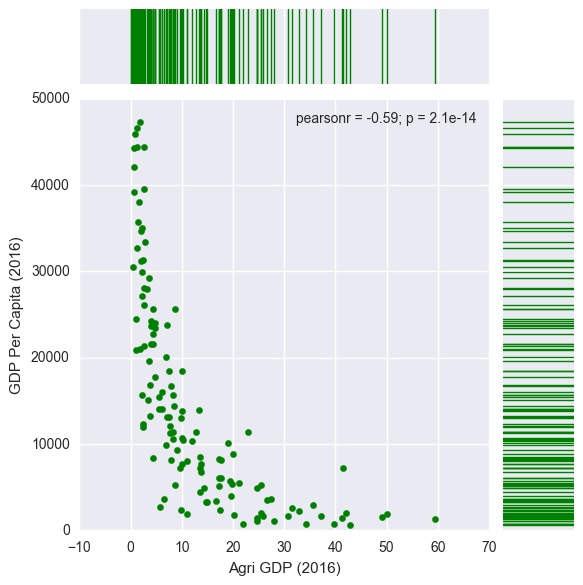

In [33]:
grid = sns.JointGrid(x=agr_key, y=gdp_key, data=countries_target_df, ylim=(0,50000))
grid.plot_joint(plt.scatter, color="g")
grid.plot_marginals(sns.rugplot, height=1, color="g")
grid.annotate(stats.pearsonr)
grid.set_axis_labels('{} ({})'.format(agr_key, target_year), '{} ({})'.format(gdp_key, target_year))

<a id='conclusions'></a>
## Conclusions

In this project, we analyzed global development indicators made available by World Bank. We looked at GDP Per Capita data for the major geographic regions of the world and found that North America continues to be the region with highest per capita GDP while East Asia & Pacific improved its standing from 5 to 4. We found that while majority of the coutries registered increase in per capita GDP, 56 of them improved their standing by growing ahead of their peers. We found that there is a positive correlation of  GDP Per Capita with % Urbanization, CO2 Emission while GDP Per Capita & Agri GDP are negatively correlated. Suggestions for future study: analyze the change in correlation coefficients from 2000 to 2016; explore correlation between GDP Per Capita and other human development indicators such as longevity, education levels, industrialization etc., 
